# 3.3 Validation
In this exercise, we showcase the approach you can utilize to quickly validate the usefulness of your satellite-derived computation. In general, the integrity of the information derived from satellite observation is often showcased by stating its accuracy or some other metrics computed using in-situ measurements. Here, we compute these metrics using the provided tools and resources on the cloud platform we are using. 

This exercise will show you how to validate results obtained on a cloud platforms. 
- Load inference datasets,
- Load ground-truth(in-situ) datasets,
- Select ROI and stations location datasets, 
- Extract point values from station, 
- Perform verification -- binary classification (true or false matching)
- Compute metrics and decide on the usefulness of the inference datasets

### Connect to our OpenEO Instance

In [1]:
from datetime import date

import openeo
import numpy as np 
import xarray as xr
import rioxarray as rio

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import pandas as pd
import geopandas as gpd
import folium
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions, geometry)

In [2]:
config = SHConfig()
config.sh_client_id = %env SH_CLIENT_ID
config.sh_client_secret = %env SH_CLIENT_SECRET

In [3]:
conn = openeo.connect('https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production')

In [4]:
conn.authenticate_basic(username=config.sh_client_id, password=config.sh_client_secret)

<Connection to 'https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production/' with BasicBearerAuth>

In [5]:
# Use this for more 
# https://github.com/openEOPlatform/sample-notebooks/blob/main/openEO%20Platfrom%20-%20Basics.ipynb
# https://github.com/Open-EO/openeo-community-examples/tree/main/python

In [6]:
# load NDSI in Zarr format
# NOTE: awaiting Sinergise backend to update the creation of ZARR files

#### Load datasets
Here, we load the snowmap computed from the previous session on data processing and validate the output using the _in-situ_ datasets for [snow cover in the European Alps](https://zenodo.org/record/5109574) with stations in our area of interest and subsequently catchment of interest.

In [7]:
# load snowmap data
# snowmap = xr.open_dataset("data/snowmap/default0") # double check

# load catchment area
catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# load snow station datasets from zenodo:: https://zenodo.org/record/5109574
station_df = pd.read_csv("data/data_daily_IT_BZ.csv") #, sep=',', index_col='Date', parse_dates=True)
station_df.head()

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill
0,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-01,NaN,NaN,NaN,NaN,19.0
1,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-02,NaN,NaN,NaN,NaN,18.0
2,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-03,NaN,NaN,NaN,NaN,18.0
3,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-04,NaN,NaN,NaN,NaN,18.0
4,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-05,NaN,NaN,NaN,NaN,17.0


In [8]:
station_df_meta = pd.read_csv("data/meta_all.csv")
station_df_meta.head()

,Provider,Name,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end
0,AT_HZB,Absdorf,15.976667,48.401667,182.0,1970.0,2016.0,1970.0,2016.0
1,AT_HZB,Ach_Burghausen,12.846389,48.148889,473.0,1990.0,2016.0,1990.0,2016.0
2,AT_HZB,Admont,14.457222,47.567778,700.0,1970.0,2016.0,1970.0,2016.0
3,AT_HZB,Afritz,13.795556,46.727500,715.0,1970.0,2016.0,1970.0,2016.0
4,AT_HZB,Alberschwende,9.849167,47.458333,717.0,1982.0,2016.0,1982.0,2016.0


#### Filter Data 
- Temporally: Filter the in-situ datasets to match the snow-map time-series,
- Spatially: Filter the in-situ datasets into the catchment area of interest

In [9]:
start_date = "2018-02-01"
end_date = "2018-06-30"

full_station = pd.merge(station_df,
                        station_df_meta,
                        how="inner",
                        on=["Provider", "Name"]).set_index(station_df.Date)

full_station = full_station.drop(["HN_year_start", "HN_year_end", "HS_year_start", "HS_year_end"], axis=1)
# full_station = full_station.reset_index(drop=True)
full_station = full_station.sort_index(ascending=True)
full_station = full_station.loc[start_date:end_date]

In [10]:
# convert lat long to geometries
snow_stations = gpd.GeoDataFrame(
    full_station,
    geometry=gpd.points_from_xy(full_station.Longitude, full_station.Latitude),
    crs="EPSG:4326"
)
# snow_stations.head()

# select stations within catchment area
catchment_stations = gpd.sjoin(snow_stations, catchment_outline, op='within')
catchment_stations.head()

/home/conda/users/c06df7d8cc38dff0b6ab13f016d9cda4bb65ebb5cdefbe46dc867e3aa29b6b61-20230801-104751-102087-199-edc-2023.07-01/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,...,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,IT_BZ,S_Martino_in_Passiria_Osservatore,2018-02-01,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
2018-02-01,IT_BZ,Rifiano_Beobachter,2018-02-01,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
2018-02-01,IT_BZ,Plata_Osservatore,2018-02-01,2.0,55.0,2.0,55.0,55.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
2018-02-01,IT_BZ,S_Leonardo_in_Passiria_Osservatore,2018-02-01,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
2018-02-01,IT_BZ,Scena_Osservatore,2018-02-01,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988


In [11]:
# drop unneccessary columns
station_columns = ['Provider', 'Name', 'Date', 'HN', 'HS', 'HN_after_qc', 'HS_after_qc',
       'HS_after_gapfill', 'Longitude', 'Latitude', 'Elevation', 'geometry']

catchment_stations = catchment_stations[station_columns]
catchment_stations

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry
Date,,,,,,,,,,,,
2018-02-01,IT_BZ,S_Martino_in_Passiria_Osservatore,2018-02-01,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268)
2018-02-01,IT_BZ,Rifiano_Beobachter,2018-02-01,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503)
2018-02-01,IT_BZ,Plata_Osservatore,2018-02-01,2.0,55.0,2.0,55.0,55.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
2018-02-01,IT_BZ,S_Leonardo_in_Passiria_Osservatore,2018-02-01,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906)
2018-02-01,IT_BZ,Scena_Osservatore,2018-02-01,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30,IT_BZ,Plata_Osservatore,2018-06-30,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
2018-06-30,IT_BZ,Scena_Osservatore,2018-06-30,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
2018-06-30,IT_BZ,Rifiano_Beobachter,2018-06-30,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503)


In [12]:
print("There are", len(np.unique(catchment_stations.Name)), "unique stations within our catchment area of interest")

There are 5 unique stations within our catchment area of interest


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<Axes: >

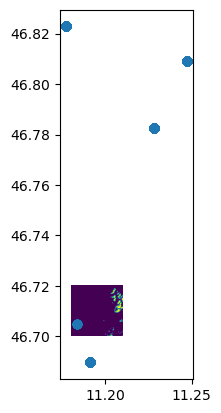

In [20]:
# display points and grid simultaneously
snow_grid_tif = rasterio.open("../../3.1_data_processing/exercises/data/snowmap_syn.tiff")
fig, ax = plt.subplots()
# transform rasterio plot to real world coords
extent = [snow_grid_tif.bounds[0], snow_grid_tif.bounds[2], snow_grid_tif.bounds[1], snow_grid_tif.bounds[3]]
ax = rasterio.plot.show(snow_grid_tif, ax=ax) #, cmap="pink")
catchment_stations.plot(ax=ax)

In [21]:
# catchment_stations.plot()
# catchment_stations.to_file("data/catchment_stations.geojson", driver="GeoJSON")

#### Binarize snow presence at station level

In [14]:
# binarize snow presence at station level. 
def snow_presence(df):
    '''
    0:: implies no snow
    1:: implies snow presence
    '''
    if df["HS_after_gapfill"] > 0:
        return 1
    elif df["HS_after_gapfill"] <= 0:
        return 0
    else:
        return 0
    
catchment_stations = catchment_stations.assign(snow_presence=catchment_stations.apply(snow_presence, axis=1))

In [15]:
catchment_stations.sample(10)

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry,snow_presence
Date,,,,,,,,,,,,,
2018-02-14,IT_BZ,Rifiano_Beobachter,2018-02-14,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0
2018-06-15,IT_BZ,Plata_Osservatore,2018-06-15,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),0
2018-06-04,IT_BZ,S_Leonardo_in_Passiria_Osservatore,2018-06-04,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
2018-05-02,IT_BZ,S_Leonardo_in_Passiria_Osservatore,2018-05-02,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
2018-06-12,IT_BZ,S_Martino_in_Passiria_Osservatore,2018-06-12,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0
2018-02-09,IT_BZ,Plata_Osservatore,2018-02-09,0.0,56.0,0.0,56.0,56.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),1
2018-05-13,IT_BZ,S_Leonardo_in_Passiria_Osservatore,2018-05-13,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
2018-02-09,IT_BZ,Rifiano_Beobachter,2018-02-09,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0
2018-06-30,IT_BZ,S_Martino_in_Passiria_Osservatore,2018-06-30,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0


#### Visualization of snow time-series at station level

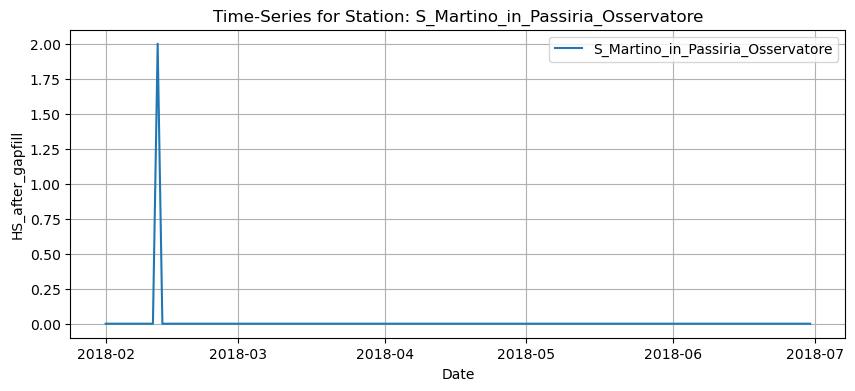

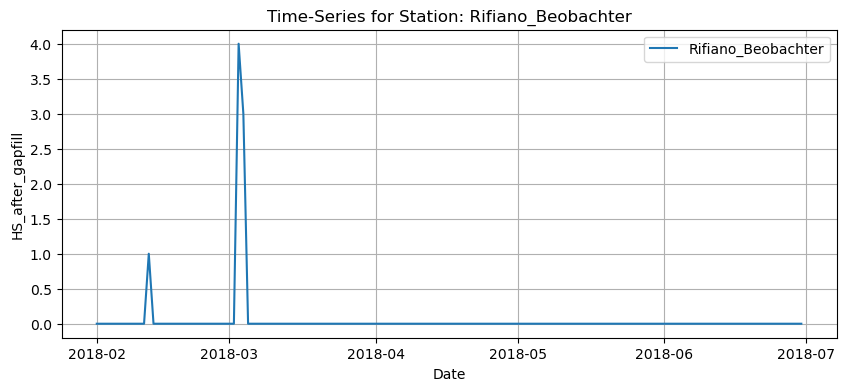

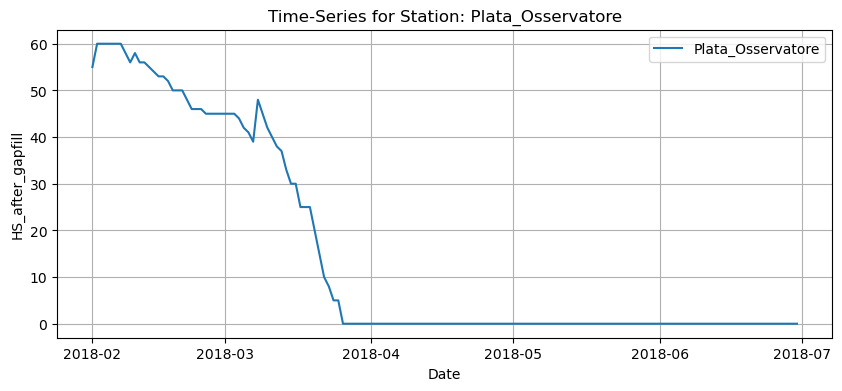

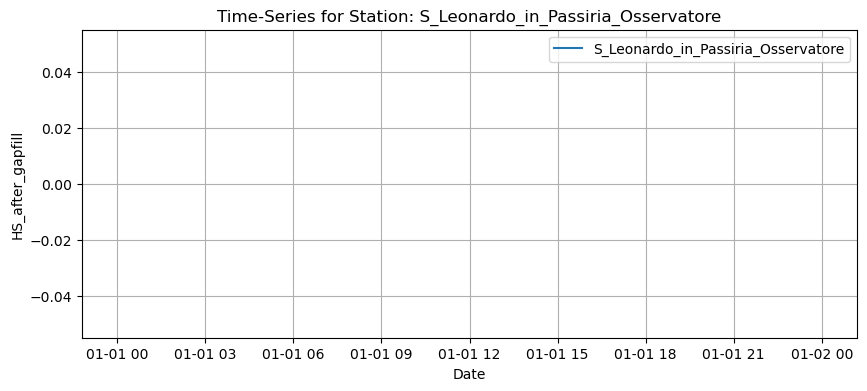

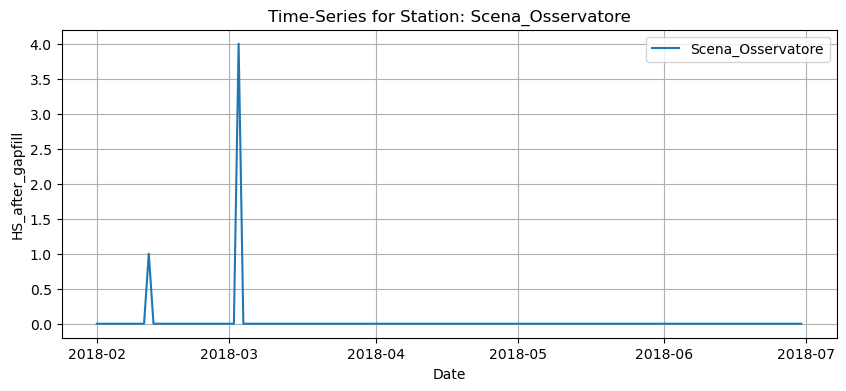

In [16]:
## TODO: show time-series of the stations
# Convert 'Date' to datetime format
# TODO: Reduce Time-series to match the start and end date for the NDSI computation, 
catchment_stations['Date'] = pd.to_datetime(catchment_stations['Date'])

# Set 'Date' as the index
catchment_stations.set_index('Date', inplace=True)

# Get unique stations
unique_stations = catchment_stations['Name'].unique()

# Plot time-series for each station
for station in unique_stations:
    station_data = catchment_stations[catchment_stations['Name'] == station]
    plt.figure(figsize=(10, 4))
    plt.plot(station_data.index, station_data['HS_after_gapfill'], label=station)
    plt.title(f'Time-Series for Station: {station}')
    plt.xlabel('Date')
    plt.ylabel('HS_after_gapfill')
    plt.legend()
    plt.grid(True)
    plt.show()

## Others

In [25]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming catchment_stations is your DataFrame with 'Date', 'Name', and 'HS_after_gapfill' columns

# # ["2018-02-01", "2018-06-30"]
# # discharge_ds = discharge_ds.loc[start_date:end_date]
# # discharge_ds = pd.read_csv('data/ADO_DSC_ITH1_0025.csv', sep=',', index_col='Time', parse_dates=True)


# catchment_stations['Date'] = pd.to_datetime(catchment_stations['Date'])
# catchment_stations.set_index('Date', inplace=True)

# unique_stations = catchment_stations['Name'].unique()

# # Create a single plot
# plt.figure(figsize=(12, 6))

# for station in unique_stations:
#     station_data = catchment_stations[catchment_stations['Name'] == station]
#     plt.plot(station_data.index, station_data['HS_after_gapfill'], label=station)

# plt.title('Time-Series for Catchment Stations')
# plt.xlabel('Date')
# plt.ylabel('HS_after_gapfill')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()  # Ensures labels are not cut off
# plt.show()

In [38]:
# load snow coverage grid
snow_grid = rio.open_rasterio("ndsi_max.tiff")
# display(snow_grid.values)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [48]:
# rasterio.plot.show(snow_grid)

In [22]:
# # display points and grid simultaneously
# snow_grid_tif = rasterio.open("ndsi_max.tiff")
# fig, ax = plt.subplots()
# # transform rasterio plot to real world coords
# extent = [snow_grid_tif.bounds[0], snow_grid_tif.bounds[2], snow_grid_tif.bounds[1], snow_grid_tif.bounds[3]]
# ax = rasterio.plot.show(snow_grid_tif, ax=ax) #, cmap="pink")
# catchment_stations.plot(ax=ax)

In [49]:
# extract values from points
snow_grid_tif = rasterio.open("ndsi_max.tiff")
coord_list = [(x, y) for x, y in zip(catchment_stations["Longitude"], catchment_stations["Latitude"])]
catchment_stations["value"] = [x for x in snow_grid_tif.sample(coord_list)]

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [26]:
catchment_stations.head(5)
# TODO: split extracted values across time and match the time to station dates as well.

,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry
Date,,,,,,,,,,,
2018-02-01,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268)
2018-02-01,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503)
2018-02-01,IT_BZ,Plata_Osservatore,2.0,55.0,2.0,55.0,55.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
2018-02-01,IT_BZ,S_Leonardo_in_Passiria_Osservatore,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906)
2018-02-01,IT_BZ,Scena_Osservatore,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)


In [27]:
# catchment_stations_filter = catchment_stations[["Name", "value"]]
# catchment_stations_filter.reset_index()
# catchment_stations_filter.loc[[0, 2], ["Name", "value"]]

In [28]:
# len(np.unique(within_catchment.Date))/365

In [ ]:
# set threshold for snow values
# Reference: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/#:~:text=The%20Sentinel%2D2%20normalized%20difference,above%200.42%20are%20usually%20snow.
# values above 0.42 are snow

# snow_grid.values
# np.unique(np.where(snow_grid.values > 0.42, 1, 0), return_counts=True) # i.e. 0 represent not snow and 1 represents snow. 

In [ ]:
# select ROI
# 'https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/exercises/data/catchment_outline.geojson'
# catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])
# folium.GeoJson(data=catchment_outline.to_json(), name='catchment').add_to(m)
# m

In [29]:
# data validation
# snow_stations.to_csv("station_gdf.csv")
